In [1]:
import sys ; sys.path.append('..')
import rrtd, run_models
import numpy as np
from msdm.domains.gridworld.mdp import GridWorld, TERMINALSTATE
from msdm.core.problemclasses.mdp import TabularMarkovDecisionProcess
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import analysis
import pandas as pd
import search_algorithms
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

tomov_interop could not load matlab


R[write to console]: Loading required package: dfidx

R[write to console]: 
Attaching package: ‘dfidx’


R[write to console]: The following object is masked from ‘package:stats’:

    filter




# Gridworld class

In [2]:
def make_simple_gridworld(*args, **kwargs):
    gw = GridWorld(*args, **kwargs)
    gw._states.remove(rrtd.frozendict(x=-1, y=-1))
    gw._actions.remove(rrtd.frozendict(dx=0, dy=0))
    for w in gw._walls:
        gw._states.remove(w)
    gw.state_list, gw.state_index
    assert sorted(gw.state_index.values()) == list(range(len(gw.state_list)))
    return gw

In [3]:
class IndexedMDPWrapper(rrtd.DeterministicShortestPathProblem, TabularMarkovDecisionProcess):
    def __init__(self, mdp, *, drop_noop_actions=False):
        self.mdp = mdp
        self.drop_noop_actions = drop_noop_actions

    def initial_state_dist(self):
        return rrtd.DictDistribution({
            self.mdp.state_index[s]: p for s, p in self.mdp.initial_state_dist().items()})
    def actions(self, si):
        actions = [
            self.mdp.action_index[a]
            for a in self.mdp.actions(self.mdp.state_list[si])
        ]
        if self.drop_noop_actions:
            return [
                ai
                for ai in actions
                if self.next_state(si, ai) != si
            ]
        return actions
    def next_state_dist(self, si, ai):
        return rrtd.DictDistribution({
            self.mdp.state_index[ns]: p
            for ns, p in self.mdp.next_state_dist(self.mdp.state_list[si], self.mdp.action_list[ai]).items()})
    def reward(self, si, ai, nsi):
        return self.mdp.reward(self.mdp.state_list[si], self.mdp.action_list[ai], self.mdp.state_list[si])
    def is_terminal(self, si):
        return self.mdp.is_terminal(self.state_list[si])

    @property
    def state_list(self):
        return [self.mdp.state_index[s] for s in self.mdp.state_list]

    def _only(self, dist):
        assert len(dist.support) == 1
        return list(dist.support)[0]

    def next_state(self, si, ai):
        return self._only(self.next_state_dist(si, ai))
    def initial_state(self):
        return self._only(self.initial_state_dist())

In [4]:
class DeterministicGridWorld(rrtd.TaskInstanceMixin, IndexedMDPWrapper):
    def __init__(self, *args, drop_noop_actions=True, **kwargs):
        IndexedMDPWrapper.__init__(self, make_simple_gridworld(*args, **kwargs), drop_noop_actions=drop_noop_actions)
        super().__init__()
        # Adding this property for rendering with rrtd.plot_graph
        self.pos = [
            (s['x'], s['y'])
            for s in self.mdp.state_list
        ]

    @property
    def state_list(self):
        return IndexedMDPWrapper.state_list.fget(self)


# Plotting subgoal values

In [5]:
mdp = '''
...#...
...#...
.......
...#...
...#...
'''
mdp = DeterministicGridWorld(
    tile_array=mdp,
    step_cost=-1,
)


In [6]:
# Checking that we filter actions correctly

from frozendict import frozendict

# Upper left corner
si = 0
assert mdp.mdp.state_list[si] == frozendict(x=0, y=0)
assert len(mdp.actions(si)) == 2

# Edges
si = 1
assert mdp.mdp.state_list[si] == frozendict(x=0, y=1)
assert len(mdp.actions(si)) == 3

si = 5
assert mdp.mdp.state_list[si] == frozendict(x=1, y=0)
assert len(mdp.actions(si)) == 3

# Central state
si = 6
assert mdp.mdp.state_list[si] == frozendict(x=1, y=1)
assert len(mdp.actions(si)) == 4

In [7]:
sgs = rrtd.task_decomposition(
    mdp,
    rrtd.all_pairs_shortest_path_distribution(mdp),
    run_models.depth_limited_dfs_analytic.iddfs_for_rrtd, tqdm=tqdm)
sgs[:10]

  0%|          | 0/32 [00:00<?, ?it/s]

[{'subgoals': (15,), 'value': -63.274512728718356},
 {'subgoals': (12,), 'value': -84.41773568018984},
 {'subgoals': (18,), 'value': -84.41773568018985},
 {'subgoals': (23,), 'value': -128.25067124104817},
 {'subgoals': (7,), 'value': -128.25067124104822},
 {'subgoals': (13,), 'value': -129.84362569609974},
 {'subgoals': (17,), 'value': -129.84362569609982},
 {'subgoals': (11,), 'value': -129.84362569609988},
 {'subgoals': (19,), 'value': -129.84362569609988},
 {'subgoals': (6,), 'value': -179.20885540970292}]

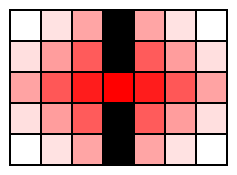

In [8]:
def render_from_values(mdp, i_to_val, *, ax=None, base_color='#ff0000', i_to_color={}, alpha_range=(0, 1), edgecolor='k'):
    assert base_color.startswith('#') and len(base_color) == 7
    import matplotlib.pyplot as plt
    from msdm.domains.gridworld.plotting import GridWorldPlotter
    gw = mdp.mdp
    def alpha_to_hex(alpha):
        return '%02x' % (int(alpha*255))
    assert sorted(gw.state_index.values()) == list(range(len(gw.state_list))), 'making sure it is simple'
    vals = np.array([i_to_val(i) if callable(i_to_val) else i_to_val[i] for i in range(len(gw.state_list))])
    vals -= np.min(vals)
    vals = vals / np.max(vals)
    vals = (alpha_range[1] - alpha_range[0]) * vals + alpha_range[0]
    lf = gw._locFeatures
    try:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(4, 4))
        gwp = GridWorldPlotter(gw=gw, ax=ax)
        gwp.plot_walls(edgecolor=edgecolor)
        gw._locFeatures = {s: [s] for s in gw.state_list}
        gwp.plot_features({
            s: i_to_color.get(gw.state_index[s], f'{base_color}{alpha_to_hex(vals[gw.state_index[s]])}')
            for s in gw.state_list},
            edgecolor=edgecolor,
        )
        #gwp.plot_outer_box()
    finally:
        gw._locFeatures = lf
render_from_values(mdp, lambda i: next(sg['value'] for sg in sgs if sg['subgoals'] == (i,)))

# Rendering traces / algorithms

In [9]:
mdp = '''
...........
...........
...........
...........
...........
'''
mdp = DeterministicGridWorld(
    tile_array=mdp,
    step_cost=-1,
)

# HACK: We avoid dropping noop actions so that we get
# stuck at boundary of line. But we do remove actions
# that change in the y direction.
mdp_line = DeterministicGridWorld(
    tile_array='....',
    step_cost=-1,
    drop_noop_actions=False,
)
# Note: removing these to have simpler 1D diffusion
mdp_line.mdp._actions.remove(rrtd.frozendict(dx=0, dy=1))
mdp_line.mdp._actions.remove(rrtd.frozendict(dx=0, dy=-1))

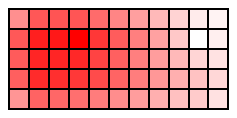

In [10]:
def rw_visits(mdp, *, return_sr=True):
    import hitting_time
    mdp_adj = rrtd.binary_adjacency_ssp(mdp, terminal_absorbing=True)
    mdp_random = mdp_adj/hitting_time.outdegree(mdp_adj)[:, None]
    assert np.allclose(mdp_random.sum(axis=1), np.ones(mdp_adj.shape[0]))
    if return_sr:
        return hitting_time.hitting_time_inv(mdp_random, return_sr=True)[mdp.initial_state()]
    else:
        return hitting_time.hitting_time_inv(mdp_random)

assert np.allclose(rw_visits(mdp_line.for_task(0, 3), return_sr=False), np.array([12, 10, 6, 0]))
assert np.isclose(rw_visits(mdp_line.for_task(0, 3)).sum(), 12)
assert np.isclose(rw_visits(mdp_line.for_task(1, 3)).sum(), 10)
assert np.isclose(rw_visits(mdp_line.for_task(2, 3)).sum(), 6)
assert np.isclose(rw_visits(mdp_line.for_task(3, 3)).sum(), 0)

render_from_values(mdp, rw_visits(mdp.for_task(
    mdp.mdp.state_index[rrtd.frozendict(y=3, x=3)],
    mdp.mdp.state_index[rrtd.frozendict(y=3, x=9)],
)))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


iddfs (no subgoal) - 1136.5 steps


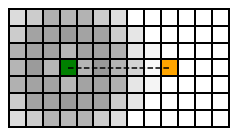

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


iddfs (with subgoal) - 102.0 steps


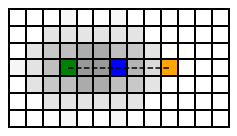

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


bfs (no subgoal) - 57.1 steps


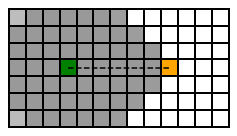

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


bfs (with subgoal) - 42.8 steps


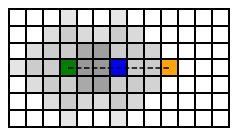

rw (no subgoal) - 227.9 steps


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


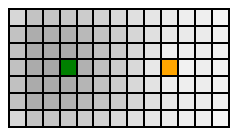

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


rw (with subgoal) - 308.8 steps


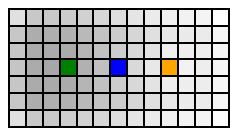

In [11]:
class SearchVisits:
    def iddfs(mdp, *, samples=100, shuffle_actions=True):
        cts = np.zeros(len(mdp.state_list))
        def cb(s):
            cts[s] = cts[s] + 1
        for _ in range(samples):
            search_algorithms.iddfs(mdp, state_visit_cb=cb, shuffle_actions=shuffle_actions)
        return cts / samples

    def bfs(mdp, *, samples=100, shuffle_actions=True):
        cts = np.zeros(len(mdp.state_list))
        for _ in range(samples):
            r = search_algorithms.bfs(mdp, shuffle_actions=shuffle_actions)
            for s in r['visited']:
                cts[s] += 1
            assert mdp.goal_state not in r['visited']
            cts[mdp.goal_state] += 1
        return cts / samples

    def rw(mdp, *, samples=None, shuffle_actions=None):
        return rw_visits(mdp)

    @classmethod
    def run(cls, mdp, seq, fn):
        if len(seq) == 2:
            s, g = seq
            sg = None
            v = fn(mdp.for_task(s, g))
        elif len(seq) == 3:
            s, sg, g = seq
            v = fn(mdp.for_task(s, sg)) + fn(mdp.for_task(sg, g))
        else:
            # hack : this isn't run
            assert False
            v = np.zeros(len(mdp.state_list))
            for s, g in zip(seq[:-1], seq[1:]):
                v += fn(mdp.for_task(s, g))
        return v, s, sg, g

    @classmethod
    def show(cls, mdp, seq, fn, *, ax=None):
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(4, 4))
        assert len(seq) in (2, 3)
        v, s, sg, g = cls.run(mdp, seq, fn)

        i_to_color = {
            s: 'green',
            g: 'orange',
        }
        if sg is not None:
            i_to_color[sg] = 'blue'

        title = f'{fn.__name__} ({"no" if sg is None else "with"} subgoal) - {v.sum():.1f} steps'
        print(title)
        #ax.set(title=title)
        render_from_values(mdp, v, ax=ax, i_to_color=i_to_color, base_color='#000000', alpha_range=(0, .4))
        return v

        '''
        offset = 0.5
        pt = mdp.mdp.state_list[s]
        plt.plot(pt['x']+offset, pt['y']+offset, 'o', color='green')
        pt = mdp.mdp.state_list[g]
        plt.plot(pt['x']+offset, pt['y']+offset, '*', color='yellow')
        if sg is not None:
            pt = mdp.mdp.state_list[sg]
            plt.plot(pt['x']+offset, pt['y']+offset, 's', color='blue')
        '''

mdp = '''
.............
.............
.............
.............
.............
.............
.............
'''
mdp = DeterministicGridWorld(
    tile_array=mdp,
    step_cost=-1,
)

import random ; random.seed(8540)
s, sg, g = (
    mdp.mdp.state_index[rrtd.frozendict(y=3, x=3)],
    mdp.mdp.state_index[rrtd.frozendict(y=3, x=6)],
    mdp.mdp.state_index[rrtd.frozendict(y=3, x=9)],
)
df = []
for fn in [SearchVisits.iddfs, SearchVisits.bfs, SearchVisits.rw]:
    if fn == SearchVisits.rw:
        draw_path_HACK = lambda: None
    else:
        def draw_path_HACK():
            plt.plot([3.5, 9.5], [3.5, 3.5], '--k') # HACK: these paths are optimal, so just depicting them.
    
    import functools
    fn = functools.wraps(fn)(functools.partial(fn, shuffle_actions=True, samples=1000))
    _, ax = plt.subplots(1, 1, figsize=(4, 4))
    flat_v = SearchVisits.show(mdp, [s, g], fn, ax=ax)
    draw_path_HACK()
    analysis.savefig(f'openfield-{fn.__name__}-flat.*')
    plt.show()

    _, ax = plt.subplots(1, 1, figsize=(4, 4))
    hier_v = SearchVisits.show(mdp, [s, sg, g], fn, ax=ax)
    draw_path_HACK()
    analysis.savefig(f'openfield-{fn.__name__}-sg.*')
    plt.show()

    df.append(dict(algo=fn.__name__, hier=False, value=flat_v))
    df.append(dict(algo=fn.__name__, hier=True, value=hier_v))
df = pd.DataFrame(df)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


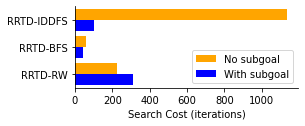

In [12]:
df['total_value'] = df.value.apply(lambda v: v.sum())
df['algo_name'] = [next(m for m in analysis.models if m.key == a).name for a in df['algo']]
df['hier_name'] = ['With subgoal' if hier else 'No subgoal' for hier in df['hier']]

f, ax = plt.subplots(figsize=(4, 1.5)) # horizontal
sns.barplot(data=df, y='algo_name', x='total_value', hue='hier_name', palette=['orange', 'blue'], saturation=1)
sns.despine()
plt.gca().legend().set_title('')
plt.ylabel('')
plt.xlabel('Search Cost (iterations)')
analysis.savefig(f'openfield-summary-bars.*')

# Draw as a graph

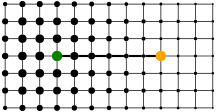

In [13]:
def draw(mdp, z, path, nodes_to_highlight):
    max_size = .6
    pairs = {
        (s, t)
        for s in path[:-1]
        for t in path[1:]
    }

    if len(nodes_to_highlight) == 2:
        s, g = nodes_to_highlight
        sg = None
    else:
        s, sg, g = nodes_to_highlight

    def edge_arg(s, ns):
        if (s, ns) in pairs:
            return {'penwidth': '9'}
        return {'penwidth': '3'}

    def node_arg(s_):
        # .5 is max size of nodes (.3 + .2)
        kw = {}
        if s_ in [s, sg, g]:
            c = (
                (9, 128, 0) if s == s_ else
                (5, 38, 255) if sg == s_ else
                (254, 165, 2) 
            )
            c = '#' + ''.join(f'{ch:02x}' for ch in c)
            kw = {'color': 'black', 'width': str(max_size), 'height': str(max_size), 'fillcolor': c}
        return {'penwidth': '0', 'fillcolor': 'black', **kw}

    return rrtd.plot_graph(
        mdp,
        #rgb=lambda s: (.8, .8, .8),
        #rgb=lambda s: (.7,) * 3,
        node_scaling=(0.1, max_size * .8),
        node_arg=node_arg,
        edge_arg=edge_arg,
        z=z,
        size='3',
    )

draw(mdp, hier_v, [
    mdp.mdp.state_index[rrtd.frozendict(y=3, x=x)]
    for x in [3, 4, 5, 6, 7, 8, 9]
], [
    mdp.mdp.state_index[rrtd.frozendict(y=3, x=3)],
    mdp.mdp.state_index[rrtd.frozendict(y=3, x=9)],
])

iddfs flat


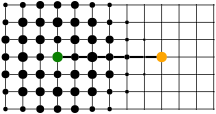

iddfs sg


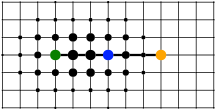

bfs flat


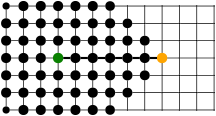

bfs sg


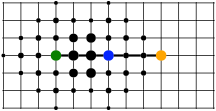

rw flat


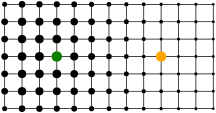

rw sg


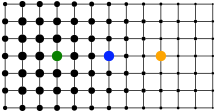

In [14]:
trajectory = [
    mdp.mdp.state_index[rrtd.frozendict(y=3, x=x)]
    for x in [3, 4, 5, 6, 7, 8, 9]
]
df = []

s, sg, g = (
    mdp.mdp.state_index[rrtd.frozendict(y=3, x=3)],
    mdp.mdp.state_index[rrtd.frozendict(y=3, x=6)],
    mdp.mdp.state_index[rrtd.frozendict(y=3, x=9)],
)

import random ; random.seed(8540)
for fn in [SearchVisits.iddfs, SearchVisits.bfs, SearchVisits.rw]:
    t = [] if fn == SearchVisits.rw else trajectory
    import functools
    fn = functools.wraps(fn)(functools.partial(fn, shuffle_actions=True, samples=1000))

    print(fn.__name__, 'flat')
    nodes_to_highlight = [s, g]
    flat_v = SearchVisits.run(mdp, nodes_to_highlight, fn)[0]
    f = draw(mdp, flat_v, t, nodes_to_highlight)
    f.attr(margin='0') # v important for PDF
    display(f)
    analysis.savesvg(f'openfield-{fn.__name__}-flat.svg', f)

    print(fn.__name__, 'sg')
    nodes_to_highlight = [s, sg, g]
    hier_v = SearchVisits.run(mdp, nodes_to_highlight, fn)[0]
    f = draw(mdp, hier_v, t, nodes_to_highlight)
    f.attr(margin='0')
    display(f)
    analysis.savesvg(f'openfield-{fn.__name__}-sg.svg', f)

    df.append(dict(algo=fn.__name__, hier=False, value=flat_v))
    df.append(dict(algo=fn.__name__, hier=True, value=hier_v))
df = pd.DataFrame(df)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


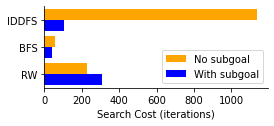

In [15]:
df['total_value'] = df.value.apply(lambda v: v.sum())
df['algo_name'] = [next(m for m in analysis.models if m.key == a).name for a in df['algo']]
df['hier_name'] = ['With subgoal' if hier else 'No subgoal' for hier in df['hier']]
df['search_algo_name'] = df['algo_name'].apply(lambda a: a[len('RRTD-'):] if a.startswith('RRTD-') else a)

f, ax = plt.subplots(figsize=(4, 1.5)) # horizontal
sns.barplot(data=df, y='search_algo_name', x='total_value', hue='hier_name', palette=['orange', 'blue'], saturation=1)
sns.despine()
plt.gca().legend().set_title('')
plt.ylabel('')
plt.xlabel('Search Cost (iterations)')
analysis.savefig(f'openfield-summary-bars.*')